# Explore Kolmogorov dataset (data/kolmogorov)
#
# This notebook inspects the provided Kolmogorov flow data files, prints shapes/stats,
# and visualizes a few representative samples (imshow and quiver for velocities).


In [6]:
# Imports and setup
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline

print('numpy', np.__version__)


numpy 2.2.5


In [7]:
# Paths and files (resolved relative to repository root)
import os
root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # if notebook opened in notebooks/
DATA_DIR = os.path.join(root, 'data', 'kolmogorov')
NPY_FILE = os.path.join(DATA_DIR, 'kf_2d_re1000_256_40seed.npy')
NPZ_FILE = os.path.join(DATA_DIR, 'kmflow_sampled_data_irregnew.npz')

print('notebook cwd:', os.getcwd())
print('repo root guessed as', root)
print('DATA_DIR resolved to', DATA_DIR)
print('DATA_DIR exists?', os.path.exists(DATA_DIR))
print('NPY exists?', os.path.exists(NPY_FILE))
print('NPZ exists?', os.path.exists(NPZ_FILE))


notebook cwd: /Users/andresforero/diffusionTest/notebooks
repo root guessed as /Users/andresforero/diffusionTest
DATA_DIR resolved to /Users/andresforero/diffusionTest/data/kolmogorov
DATA_DIR exists? True
NPY exists? True
NPZ exists? True


In [8]:
# Utility functions for summary and visualization
import numpy as np

def summarize(arr, name='array'):
    arr = np.asarray(arr)
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, min={np.nanmin(arr):.4g}, max={np.nanmax(arr):.4g}, mean={np.nanmean(arr):.4g}, std={np.nanstd(arr):.4g}")
    print('  nan:', np.isnan(arr).any(), 'inf:', np.isinf(arr).any())


def visualize_sample(array, idx=0, title='sample'):
    a = np.asarray(array)
    if a.ndim == 4:
        # common: N,C,H,W or N,H,W,C - try to detect
        if a.shape[1] <= 4 and a.shape[1] > 0:
            sample = a[idx]
            # assume N,C,H,W -> convert to C,H,W
            if sample.shape[0] <= 4:
                sample = sample
        else:
            # assume N,H,W,C
            sample = a[idx].transpose(2,0,1)
    elif a.ndim == 3:
        # could be N,H,W or C,H,W or H,W,C
        if a.shape[0] <= 4:
            # likely C,H,W
            sample = a
        else:
            # likely N,H,W
            sample = a[0]
            if sample.ndim == 2:
                sample = np.expand_dims(sample,0)
    elif a.ndim == 2:
        sample = a
    else:
        raise ValueError('Unsupported ndim='+str(a.ndim))

    # if sample is C,H,W -> convert to H,W,C for plotting channels side-by-side
    if sample.ndim == 3 and sample.shape[0] <= 8:
        C = sample.shape[0]
        fig, axs = plt.subplots(1, C, figsize=(4*C,4))
        if C == 1:
            axs = [axs]
        for i in range(C):
            im = axs[i].imshow(sample[i], origin='lower', cmap='RdBu')
            axs[i].set_title(f'ch{i}')
            fig.colorbar(im, ax=axs[i])
        plt.suptitle(title)
        plt.show()
        if C >= 2:
            u = sample[0]
            v = sample[1]
            H,W = u.shape
            step = max(1, H//32)
            X, Y = np.meshgrid(np.arange(0,W,step), np.arange(0,H,step))
            plt.figure(figsize=(5,5))
            plt.imshow(np.hypot(u,v), origin='lower', cmap='magma')
            plt.quiver(X, Y, u[::step,::step], v[::step,::step], color='white', scale=50)
            plt.title('velocity magnitude + quiver (subsampled)')
            plt.show()
    else:
        plt.figure(figsize=(6,6))
        plt.imshow(sample, origin='lower', cmap='RdBu')
        plt.colorbar()
        plt.title(title)
        plt.show()


def radial_spectrum(field):
    F = np.fft.fftshift(np.fft.fft2(field))
    P = np.abs(F)**2
    H,W = P.shape
    cy, cx = H//2, W//2
    y, x = np.indices((H,W))
    r = np.hypot(x-cx, y-cy).astype(np.int32)
    rmax = int(min(cx, cy))
    ps = np.bincount(r.ravel(), P.ravel())[:rmax]
    cnt = np.bincount(r.ravel())[:rmax]
    ps = ps / (cnt + 1e-12)
    return ps


def plot_spectrum(field, label='spectrum'):
    ps = radial_spectrum(field)
    k = np.arange(len(ps))
    plt.loglog(k[1:], ps[1:], '-o')
    plt.xlabel('k (radial)')
    plt.ylabel('power')
    plt.title(label)
    plt.show()


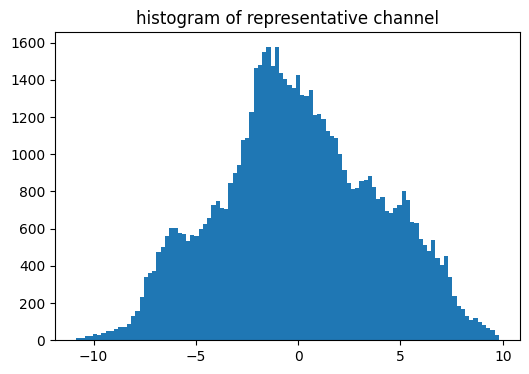

NaN count: 0 Inf count: 0


In [4]:
# Histogram and NaN/Inf checks
import numpy as np

# pick a representative array if exists
picked = None
if os.path.exists(NPY_FILE):
    a = np.load(NPY_FILE)
    if a.ndim == 4:
        picked = a[0,0]
    elif a.ndim == 3:
        picked = a[0]

if picked is None and os.path.exists(NPZ_FILE):
    npz = np.load(NPZ_FILE, allow_pickle=True)
    for k in npz.files:
        arr = np.asarray(npz[k])
        if arr.ndim >= 2:
            picked = arr.reshape(arr.shape[0], -1)[0]
            break

if picked is not None:
    plt.figure(figsize=(6,4))
    plt.hist(picked.ravel(), bins=100)
    plt.title('histogram of representative channel')
    plt.show()
    print('NaN count:', np.isnan(picked).sum(), 'Inf count:', np.isinf(picked).sum())
else:
    print('No representative array found for histogram')


In [5]:
# Save a couple of figs (if any) to notebooks/figs
outdir = 'notebooks/figs'
os.makedirs(outdir, exist_ok=True)
plt.savefig(os.path.join(outdir, 'last_figure.png'))
print('Saved last_figure.png to', outdir)


Saved last_figure.png to notebooks/figs


<Figure size 640x480 with 0 Axes>

# Closing notes

This notebook inspects the Kolmogorov dataset and shows how to visualize velocity channels (u,v) using imshow and quiver.

Next steps:
- Adjust the `visualize_sample` helper if your arrays use a different channel layout.
- Add more automated checks (e.g., train/val split, normalization statistics) before training.


In [5]:
# Check notebook working directory
import os
print('cwd:', os.getcwd())
print('list current dir:', os.listdir('.'))
print('list data dir exists?', os.path.exists('data'))
if os.path.exists('data'):
    print('data contents:', os.listdir('data'))


cwd: /Users/andresforero/diffusionTest/notebooks
list current dir: ['explore_data.ipynb']
list data dir exists? False



--- /Users/andresforero/diffusionTest/data/processed/downsampled_64.npz
loaded /Users/andresforero/diffusionTest/data/processed/downsampled_64.npz key= x shape= (40, 64, 64, 320) dtype= float32
sample HxW, channels= 64 64 320
loaded /Users/andresforero/diffusionTest/data/processed/downsampled_64.npz key= x shape= (40, 64, 64, 320) dtype= float32
sample HxW, channels= 64 64 320


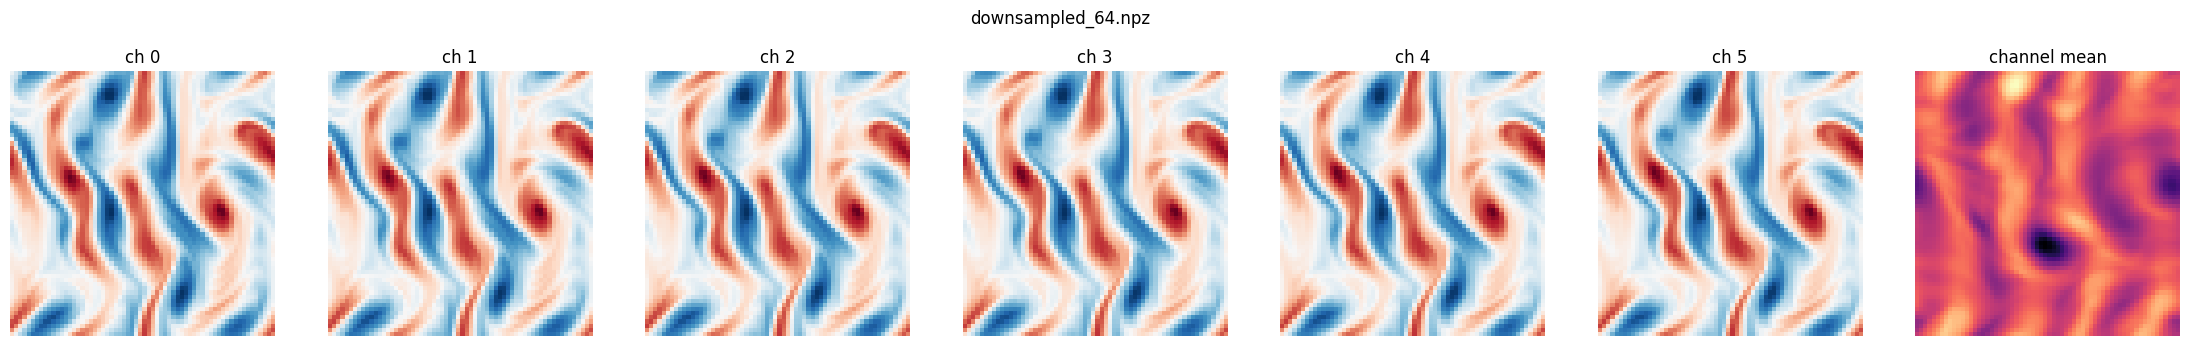

wrote /Users/andresforero/diffusionTest/notebooks/figs/downsampled_64.png


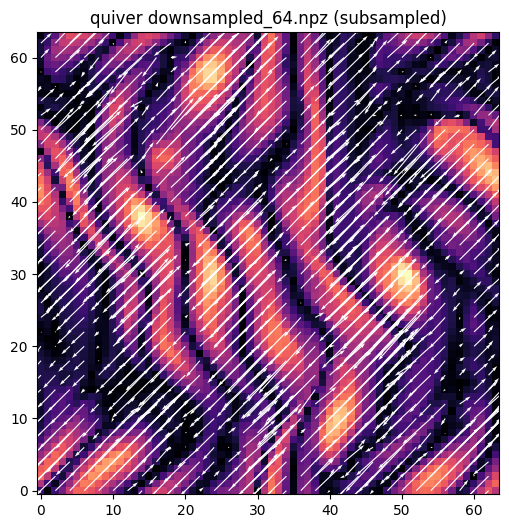

wrote /Users/andresforero/diffusionTest/notebooks/figs/downsampled_64_quiver.png

--- /Users/andresforero/diffusionTest/data/processed/downsampled_32.npz
loaded /Users/andresforero/diffusionTest/data/processed/downsampled_32.npz key= x shape= (40, 32, 32, 320) dtype= float32
sample HxW, channels= 32 32 320
loaded /Users/andresforero/diffusionTest/data/processed/downsampled_32.npz key= x shape= (40, 32, 32, 320) dtype= float32
sample HxW, channels= 32 32 320


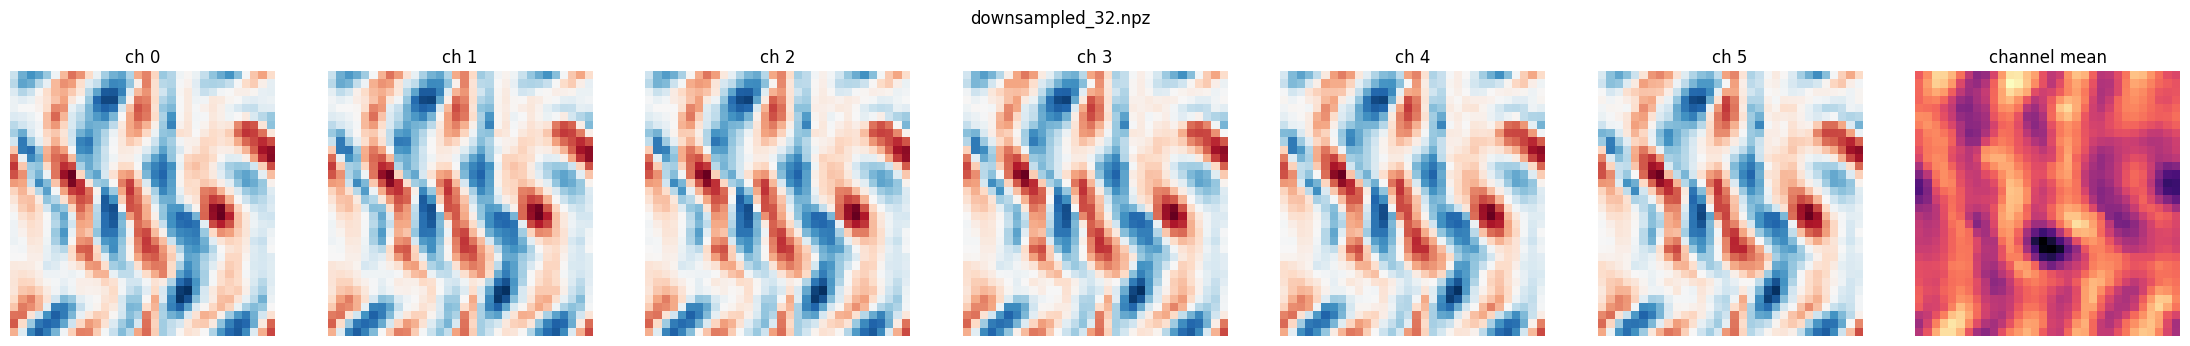

wrote /Users/andresforero/diffusionTest/notebooks/figs/downsampled_32.png


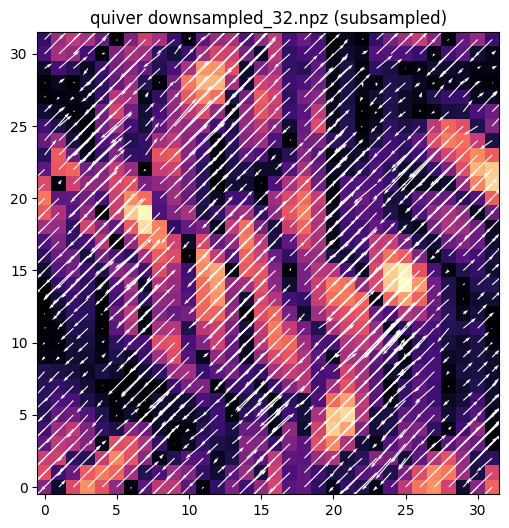

wrote /Users/andresforero/diffusionTest/notebooks/figs/downsampled_32_quiver.png


In [9]:
# Visualize processed downsampled datasets (64 and 32)
import os
processed_dir = os.path.join(root, 'data', 'processed')
files = [
    os.path.join(processed_dir, 'downsampled_64.npz'),
    os.path.join(processed_dir, 'downsampled_32.npz'),
]

outdir = os.path.join(root, 'notebooks', 'figs')
os.makedirs(outdir, exist_ok=True)

for p in files:
    print('\n---', p)
    if not os.path.exists(p):
        print('missing', p)
        continue
    npz = np.load(p, allow_pickle=True)
    key = npz.files[0]
    data = npz[key]
    print('loaded', p, 'key=', key, 'shape=', data.shape, 'dtype=', data.dtype)

    # data expected to be (N,H,W,C) or (N,C,H,W). Convert to (N,H,W,C)
    if data.ndim != 4:
        print('unexpected ndim', data.ndim)
        continue
    if data.shape[-1] <= 8 and data.shape[-1] <= data.shape[1]:
        # already (N,H,W,C)
        arr = data
    elif data.shape[1] <= 8:
        # (N,C,H,W) -> move axis
        arr = np.moveaxis(data, 1, -1)
    else:
        # default assume (N,H,W,C)
        arr = data

    sample = arr[0]  # H,W,C
    C = sample.shape[-1]
    print('sample HxW, channels=', sample.shape[0], sample.shape[1], C)

    # show a few first channels (up to 6) as images
    nch = min(6, C)
    fig, axs = plt.subplots(1, nch+1, figsize=(4*(nch+1),4))
    for i in range(nch):
        m = sample[..., i]
        axs[i].imshow(m, origin='lower', cmap='RdBu')
        axs[i].set_title(f'ch {i}')
        axs[i].axis('off')
    # also show channel-mean
    mean_field = np.mean(sample, axis=-1)
    im = axs[nch].imshow(mean_field, origin='lower', cmap='magma')
    axs[nch].set_title('channel mean')
    axs[nch].axis('off')
    plt.suptitle(os.path.basename(p))
    outpng = os.path.join(outdir, os.path.basename(p).replace('.npz','.png'))
    plt.savefig(outpng, bbox_inches='tight')
    plt.show()
    print('wrote', outpng)

    # if at least 2 channels, show quiver using channels 0 and 1 (subsampled)
    if C >= 2:
        u = sample[..., 0]
        v = sample[..., 1]
        H, W = u.shape
        step = max(1, H//32)
        X, Y = np.meshgrid(np.arange(0,W,step), np.arange(0,H,step))
        plt.figure(figsize=(6,6))
        plt.imshow(np.hypot(u, v), origin='lower', cmap='magma')
        plt.quiver(X, Y, u[::step,::step], v[::step,::step], color='white', scale=50)
        plt.title(f'quiver {os.path.basename(p)} (subsampled)')
        qpng = os.path.join(outdir, os.path.basename(p).replace('.npz','_quiver.png'))
        plt.savefig(qpng, bbox_inches='tight')
        plt.show()
        print('wrote', qpng)
